Keith Chamberlain
Tue June 8: The wee hours

The purpose of this repo is to document the data exploration and analyses of Lending Club data for accepted and rejected loans, provided on Kaggle by [wordsforthewise](https://www.kaggle.com/wordsforthewise). The data span from 2007 to 2018 q4. 

# Created Repo

Generated new repo "To_Loan_or_Not" (To Loan... That is the question). Additions made to the .gitignore file to include the /data folder, as well as the jupyter notebooks save files and directory. 

# Data File Exploration

    Lending_Club.zip downloaded to the data folder. Unzipped *accepted_2007_to_2018Q4.csv.gz* (392.6 Mb) and *rejected_2007_to_2018Q4.csv.gz* (255.5 Mb) gzip compressed files totalling 648.1 Mb. This is missleading, as these are compressed files. Uncompressed, as accepted.csv and rejected.csv, these files are 1.68 Gb and 1.78 Gb on this system.


In [1]:
!pwd

/Users/keithchamberlain/DSI/capstones/To_Loan_or_Not/notebooks


In [2]:
!head -n 2 ../data/accepted.csv

id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,to

In [3]:
!head -n 4 ../data/rejected.csv

Amount Requested,Application Date,Loan Title,Risk_Score,Debt-To-Income Ratio,Zip Code,State,Employment Length,Policy Code
1000.0,2007-05-26,Wedding Covered but No Honeymoon,693.0,10%,481xx,NM,4 years,0.0
1000.0,2007-05-26,Consolidating Debt,703.0,10%,010xx,MA,< 1 year,0.0
11000.0,2007-05-27,Want to consolidate my debt,715.0,10%,212xx,MD,1 year,0.0


## Columns status

There are major differences between the columns of the two, separate datasets. Most of the columns in the *accepted.csv* data are related to loan status over time, and most of those values are missing. I was hoping to compare more features between the datasets. I don't have a data dictionary, as Lending Club is no longer providing a description of the columns on their website. Right now I can see the following shared between them with Rejected on the left: 

  - Amout requested | Loand Amount (close enough perhaps?)
  - Risk_Score | fico_range_high, fico_range_low (their average?)
  - Debt-To-Income Ratio | dti
  - Zip Code | zip_code
  - State | addr_state
  - Employment Length | emp_length
  
As an alternative to relating the accepted/rejected groups, there are plenty of data in the accepted list to predict who defaulted. In any event, time to import some data in Python!

In [4]:
''' Imports '''
import numpy as np
import pandas as pd
pd.options.display.max_rows=200

import os
import timeit as time
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline

In [5]:
first_run = False

## Dataset Descriptions

These data, as stated, differ in content for each file.

### Accepted Loans Data File

Accepted.csv is 151 columns x 260,702 rows. Of the 151 column, 113 columns import as numeric automatically. Most of these columns have something to do with the life of the loan rather than the decision to take on the loan in the first place. Most of these column values are `NaN`. These columns could be interesting regarding whether the loanee defaulted over the life of the loan, and whether that could be predicted, however, there is not enough time to assess all of these scenarios. Thus, I will focus on the shared features between the accepted and rejected loans. 

### Rejected Loans Data File

Rejected.csv is 9 columns x 2,260,702 rows. Of the 9 columns, three import as numeric, of which two vary: Amount Requested, and Risk_Score. Debt-to-Income Ratio and Zipcode imported as "Object". 

Debt-to-Income Ratio has a % sign in it. Pandas doesn't coerce that type to numeric, so I'll strip out the % in the OS. The 2 min 13 seconds is time well spent to prevent having to do this during each import with regex and the python engine instead of the C engine (slows things down to minutes instead of 15 s).


In [6]:
!pwd
if first_run:
    t0 = time.default_timer()
    !cat ../data/rejected.csv | tr -d '[\%]' > ../data/newrej.csv
    t1 = time.default_timer() - t0
    print(t1)

/Users/keithchamberlain/DSI/capstones/To_Loan_or_Not/notebooks


In [7]:
''' 

Grab the number of records in each file using the OS commands, then import the data into python. Record the
time taken and the number of rows for each dataset. 

'''
t0 = time.default_timer()
# Read the number of rows, if first_run, and store in file
if first_run:
    !wc -l ../data/accepted.csv > ../data/accepted.wc
    !wc -l ../data/rejected.csv > ../data/rejected.wc

# Read line counts
acceptedwc = pd.read_csv("../data/accepted.wc", delimiter=" ", header = None).loc[0,1]
rejectedwc = pd.read_csv("../data/rejected.wc", delimiter=" ", header = None).loc[0,1]
t1 = time.default_timer() - t0
print(t1, acceptedwc, rejectedwc)

0.05946596799999959 2260702 27648742


## Grab the Headers from the files

In [8]:
''' Grab the number of columns in each file '''

accept_header = pd.read_csv("../data/accepted.csv", delimiter=",", nrows=0)
reject_header = pd.read_csv("../data/rejected.csv", delimiter=",", nrows=0)
# print(accept_header.columns[[2, 27, 28, 24, 22, 23, 11]])
# print(accept_header.columns[12:])
# print(reject_header.columns)
# print(reject_header.columns[[0, 3, 4, 5, 6, 7]])

In [9]:
# print(accepted_data['zip_code'])
# print(rejected_data['Zip Code'])

## n% Random Sample

To start, we will be taking a 10% random sample of each of the 1.68, and 1.78 Gb files in order to work with something in memory within reasonable time frames. The row 0 (headers) needs to be ensured to be a part of that set, so the header does not get mixed up with the data and throw off the data types. 

In order to take a 10% random sample, I will *skip* a 90% random sample of rows. 

In [10]:
''' Import the files and work with a random sample '''

rndm = np.random.default_rng()
pct_rnd_sample = 0.1 10% of the data
    #skip = sorted(random.sample(range(n),n-s))
    #df = pandas.read_csv(filename, skiprows=skip)
t0 = time.default_timer()
accepted_skip = sorted(rndm.choice(a = acceptedwc, size = acceptedwc - int(pct_rnd_sample*acceptedwc), 
                                   replace=False))
t1 = (time.default_timer(), time.default_timer()-t0)
rejected_skip = sorted(rndm.choice(a = rejectedwc, size = rejectedwc - int(pct_rnd_sample*rejectedwc), 
                                   replace=False))
t2 = time.default_timer() - t1[0]
print(t1[1], t2)

1.669335792 31.972213933000003


### Ensure Row 0 is Always Skipped

In [11]:
accepted_skip2 = [0]
rejected_skip2 = [0]
if not 0 in accepted_skip:
    accepted_skip2.extend(list(accpted_skip))
    accepted_skip = np.array(accepted_skip2)
if not 0 in rejected_skip:
    rejected_skip2.extend(list(rejected_skip))
    rejected_skip = np.array(rejected_skip2)

In [12]:
'''
Do the import!!! Not using python engine due to complex regex delimiter - wasn't necessary in this file.

'''
t0 = time.default_timer()
accepted_data = pd.read_csv("../data/accepted.csv", delimiter=",", header = None, skiprows=accepted_skip, 
                            names=accept_header.columns, low_memory=False)#, nrows=10)
t1 = time.default_timer() - t0
print(t1)

11.556942480000004


In [13]:
'''
Do the import!!! - Pre stripped delimiters/excess characters ported to new file. 

'''
t0 = time.default_timer()
rejected_data = pd.read_csv("../data/newrej.csv", delimiter=",", header = None, skiprows=rejected_skip, 
                            names=reject_header.columns, low_memory=False)#, nrows=10)
t1 = time.default_timer() - t0
print(t1)

16.356606559


In [14]:
accepted_data.info(verbose=True, show_counts=True, memory_usage='deep')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226070 entries, 0 to 226069
Data columns (total 151 columns):
 #    Column                                      Non-Null Count   Dtype  
---   ------                                      --------------   -----  
 0    id                                          226070 non-null  object 
 1    member_id                                   0 non-null       float64
 2    loan_amnt                                   226067 non-null  float64
 3    funded_amnt                                 226067 non-null  float64
 4    funded_amnt_inv                             226067 non-null  float64
 5    term                                        226067 non-null  object 
 6    int_rate                                    226067 non-null  float64
 7    installment                                 226067 non-null  float64
 8    grade                                       226067 non-null  object 
 9    sub_grade                                   226067 non-nu

In [15]:
rejected_data.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2764874 entries, 0 to 2764873
Data columns (total 9 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   Amount Requested      2764874 non-null  float64
 1   Application Date      2764874 non-null  object 
 2   Loan Title            2764741 non-null  object 
 3   Risk_Score            915723 non-null   float64
 4   Debt-To-Income Ratio  2764874 non-null  float64
 5   Zip Code              2764832 non-null  object 
 6   State                 2764872 non-null  object 
 7   Employment Length     2670078 non-null  object 
 8   Policy Code           2764775 non-null  float64
dtypes: float64(4), object(5)
memory usage: 189.8+ MB


In [16]:
accepted_data.describe().T

,count,mean,std,min,25%,50%,75%,max
member_id,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan_amnt,226067.0,15068.709608,9188.267180,5.000000e+02,8000.0000,13000.000,20000.0000,4.000000e+04
funded_amnt,226067.0,15063.580487,9186.778873,5.000000e+02,8000.0000,13000.000,20000.0000,4.000000e+04
funded_amnt_inv,226067.0,15044.640877,9191.070421,0.000000e+00,8000.0000,13000.000,20000.0000,4.000000e+04
int_rate,226067.0,13.093869,4.836445,5.310000e+00,9.4900,12.620,15.9900,3.099000e+01
installment,226067.0,446.667104,267.454692,4.930000e+00,252.1400,379.280,593.6000,1.714540e+03
annual_inc,226067.0,77983.295425,80302.054756,0.000000e+00,46000.0000,65000.000,93000.0000,9.930475e+06
dti,225908.0,18.877972,14.594595,0.000000e+00,11.9100,17.870,24.5300,9.990000e+02
delinq_2yrs,226064.0,0.307139,0.875500,0.000000e+00,0.0000,0.000,0.0000,5.800000e+01
fico_range_low,226067.0,698.661680,33.120111,6.300000e+02,675.0000,690.000,715.0000,8.450000e+02


## Describe Data

In [17]:
rejected_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Amount Requested,2764874.0,13129.120879,14948.281747,0.0,4900.00,10000.00,20000.00,300000.00
Risk_Score,915723.0,628.213143,89.890896,0.0,591.00,637.00,675.00,990.00
Debt-To-Income Ratio,2764874.0,160.429140,30431.466483,-1.0,8.07,19.97,36.58,50000031.49
Policy Code,2764775.0,0.006349,0.112508,0.0,0.00,0.00,0.00,2.00


In [18]:
''' 
Recode Employment Length

'''
names = {"< 1 year": 0, "1 year": 1,  "2 years": 2, "3 years": 3, "4 years": 4,  "5 years": 5,"6 years": 6,   
         "7 years": 7, "8 years": 8, "9 years": 9,  "10+ years": 10,  np.nan: np.nan}
rejected_data["Employment Length"].replace(to_replace=names, inplace=True)
accepted_data["emp_length"].replace(to_replace=names, inplace=True)

In [19]:
rejected_data["Employment Length"].unique().sort()

In [20]:
# Looking at Debt to Income Ratio
#sum_rej_dti = sum(rejected_data['Debt-To-Income Ratio']>=200)
sum(rejected_data['Debt-To-Income Ratio']==999)

0

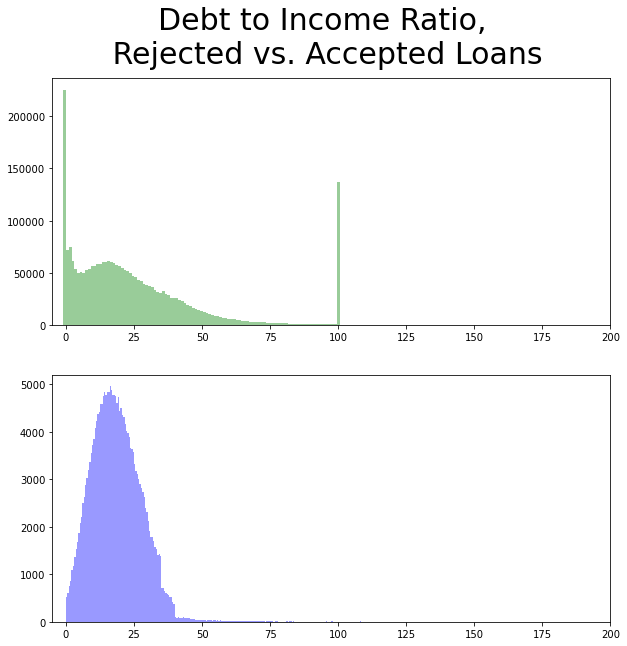

In [21]:
# Looking at Debt to Income Ratio
indx = rejected_data["Debt-To-Income Ratio"] <=200
fig, ax = plt.subplots(2, figsize=(10,10))
ax[0].hist(rejected_data['Debt-To-Income Ratio'][indx], color="green", alpha=0.4, bins=200)
plt.suptitle("Debt to Income Ratio,\n Rejected vs. Accepted Loans", size=30)
#ax[0].set_ylim(-5,2e7)
ax[0].set_xlim([-5,200])
ax[1].hist(accepted_data['dti'], color="blue", alpha=0.4, bins=2000)
ax[1].set_xlim([-5,200])
plt.show()

In order to see the distributions, the data had to be truncated to 200%. The max value for accepted loans was 999%, of which there were 19 values in the 0.1% sample. The next highest value listed was 457% with a count of 1 and 294% with a count of 1. Its likely that those 999% counts are missing values, as 999 is a common missing value entry. 

Single value entries for accepted loans for debt to income ratio went down to below 100 before counts started to climb. This is different from rejected loans, which had zero counts at 999%, and counts above 1 continued well above 400%. However, there exists clear truncation at 100% and -1%. The 100% may have been a prior max value, which is difficult to say since the data dictionary isn't around anymore. I shall assume the -1's are missing values, and truncate both datasets at 100%, so the range will be from [0, 100+]. 

## Employment Length


In [22]:
totl = sum(rejected_data["Debt-To-Income Ratio"]>-2)
print(sum(rejected_data['Debt-To-Income Ratio']==100)/totl*100)
print(sum(rejected_data['Debt-To-Income Ratio']==-1)/totl*100)
print(sum(rejected_data['Debt-To-Income Ratio']==0)/totl*100)
print(sum(rejected_data['Debt-To-Income Ratio']>100)/totl*100)
print(sum((rejected_data["Debt-To-Income Ratio"]>0) & (rejected_data["Debt-To-Income Ratio"] < 100))/totl*100)

4.91262892992592
4.344465606750977
3.787297359662683
2.9159737478091223
84.0396343558513


In [23]:
rejected_data['Employment Length'].describe()

count    2.670078e+06
mean     7.143728e-01
std      1.967554e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+01
Name: Employment Length, dtype: float64

In [24]:
rejected_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2764874 entries, 0 to 2764873
Data columns (total 9 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Amount Requested      float64
 1   Application Date      object 
 2   Loan Title            object 
 3   Risk_Score            float64
 4   Debt-To-Income Ratio  float64
 5   Zip Code              object 
 6   State                 object 
 7   Employment Length     float64
 8   Policy Code           float64
dtypes: float64(5), object(4)
memory usage: 189.8+ MB


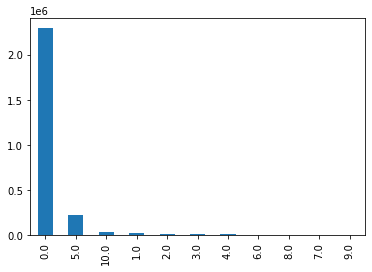

In [25]:
#fix, ax = plt.subplots(2,1, figsize=(10,10))
plt1 = rejected_data['Employment Length'].value_counts().plot(kind="bar")

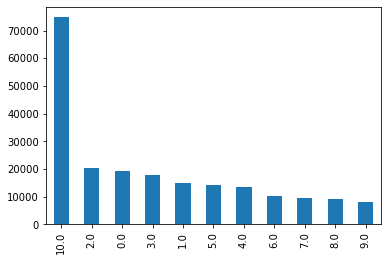

In [26]:
plt2 = accepted_data["emp_length"].value_counts().plot(kind="bar")

<BarContainer object of 11 artists>

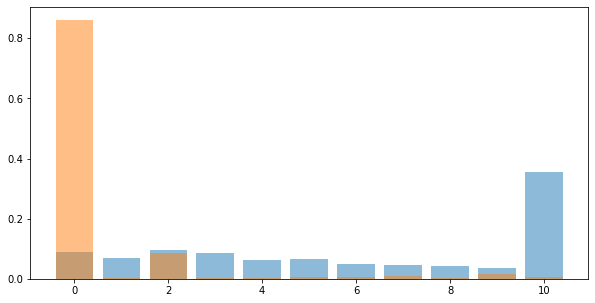

In [27]:
rejtotl = rejected_data["Employment Length"].count()
acctotl = accepted_data["emp_length"].count()
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.bar(x=[0,8,7,9,10,4,3,1,2,5,6], height=accepted_data["emp_length"].value_counts(sort=False)/acctotl, 
       alpha=0.5)
ax.bar(x=[0,5,10,1,2,3,4,6,8,7,9], height=rejected_data["Employment Length"].value_counts(sort=False)/rejtotl,
       alpha=0.5)


In [49]:
Emp_lt10 = 0*(rejected_data["Employment Length"]<10)+1*(accepted_data["emp_length"]<10)
Emp_greq10= 0*(rejected_data["Employment Length"]==10)+1*(accepted_data["emp_length"]==10)
print(len(Emp_lt10),len(Emp_greq10))
print(Emp_lt10[:10])

2764874 2764874
0    0.0
1    1.0
2    1.0
3    1.0
4    1.0
5    1.0
6    1.0
7    0.0
8    1.0
9    1.0
dtype: float64


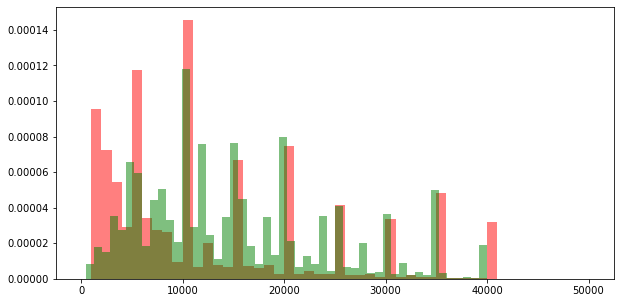

In [38]:
fig, ax = plt.subplots(1,1, figsize=(10,5), sharex=True)
rejreqtotl = rejected_data["Amount Requested"].sum()
accreqtotl = accepted_data["loan_amnt"].sum()

ax.hist(rejected_data["Amount Requested"][rejected_data["Amount Requested"]<50000], 
        bins=50, alpha=0.5, density=True, color = "red");
ax.hist(accepted_data["loan_amnt"][accepted_data["loan_amnt"]<50000], 
        bins=50, alpha=0.5, density=True, color="green");

In [39]:
rejabove20k = (rejected_data["Amount Requested"]>20000).sum()
rejtotlreq = (rejected_data["Amount Requested"]>-1).sum()

accabove20k = (accepted_data["loan_amnt"]>20000).sum()
acctotlreq = (accepted_data["loan_amnt"]>-1).sum()
print(rejabove20k/rejtotlreq*100)
print(accabove20k/acctotlreq*100)
print(accepted_data["loan_amnt"].median(), rejected_data["Amount Requested"].median())

18.835180192659774
23.802677967151332
13000.0 10000.0


In [53]:
reqlt10 = 0*(rejected_data["Amount Requested"]<10000)+ 1*(accepted_data["loan_amnt"]<10000)
reqgreq10= 0*(rejected_data["Amount Requested"]>=10000) + 1*(accepted_data["loan_amnt"]>=10000)
print(len(reqlt10), len(reqgreq10))
print(np.sum(reqlt10), np.sum(reqgreq10))

2764874 2764874
70724.0 155343.0


In [51]:
df = pd.DataFrame({"employ_lt10_year":Emp_lt10, "employ_gteq10_year":Emp_greq10, 
                   "ask_lt10k": reqlt10, "ask_gteq10k":reqgreq10})

In [52]:
df.head()

,employ_lt10_year,employ_gteq10_year,ask_lt10k,ask_gteq10k
0,0.0,1.0,0.0,1.0
1,1.0,0.0,0.0,1.0
2,1.0,0.0,0.0,1.0
3,1.0,0.0,0.0,1.0
4,1.0,0.0,0.0,1.0


In [74]:
df.iloc[:,0]

0          0.0
1          1.0
2          1.0
3          1.0
4          1.0
          ... 
2764869    NaN
2764870    NaN
2764871    NaN
2764872    NaN
2764873    NaN
Name: employ_lt10_year, Length: 2764874, dtype: float64